In [1]:
import os

In [2]:
os.environ["DGLBACKEND"] = "pytorch"

In [3]:
import torch 
import pandas as pd
import dgl
from dgl.data import DGLDataset
import dgl.function as fn
import numpy as np

In [4]:
ds = dgl.data.CSVDataset('./DGL_playground/toy_dataset/')

Done loading data from cached files.


In [5]:
g = ds[0]

In [6]:
print(g)


Graph(num_nodes=10, num_edges=20,
      ndata_schemes={' na2': Scheme(shape=(), dtype=torch.int64), ' na1': Scheme(shape=(), dtype=torch.int64)}
      edata_schemes={'ea2': Scheme(shape=(), dtype=torch.int64), 'ea1': Scheme(shape=(), dtype=torch.int64), 'w': Scheme(shape=(), dtype=torch.int64)})


### Define Weights

The weights need to be constant along any bi-directed edge. DGL does not provide a function to ensure this happens. Currently a for loop is being used to ensure identical weights along edges - a better solution needs to be found to ensure scalability of the model.

In [7]:
g.edata['w'] = torch.rand(g.num_edges(),1)
# g.edata['w']

In [8]:
g.edges("all")

(tensor([0, 0, 0, 1, 1, 2, 2, 3, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8]),
 tensor([1, 2, 3, 0, 2, 0, 1, 0, 4, 5, 3, 5, 3, 4, 7, 8, 6, 8, 6, 7]),
 tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
         18, 19]))

In [9]:
# Obtain source, destination and edge ids for all edges
[src, dst, eid] = g.edges(form = 'all')

# Loop through edges to identify bi-directional edges to then assign same weights
# This loop can be optimized but ideally needs to be replaced with an parallelisable function
for i in eid:
    for j in eid:
        if (src[i] == dst[j] and dst[i] == src[j]): #For edges with same nodes
            g.edata['w'][j] = g.edata['w'][i]
            break
g.edata['w']

tensor([[0.1062],
        [0.1417],
        [0.7484],
        [0.1062],
        [0.2712],
        [0.1417],
        [0.2712],
        [0.7484],
        [0.4586],
        [0.9633],
        [0.4586],
        [0.3179],
        [0.9633],
        [0.3179],
        [0.6236],
        [0.5601],
        [0.6236],
        [0.0011],
        [0.5601],
        [0.0011]])

In [10]:
#Create wealth per node/agent in the network as a node feature/attribute
g.ndata['k'] = torch.rand(g.num_nodes(),1)*1000

In [11]:
#Create savings propensity as a node features per agent
g.ndata['lambda'] = torch.rand(g.num_nodes(),1)

In [12]:
#Initialize some base node attributes (0s, and 1s)
g.ndata['zeros'] = torch.zeros(g.num_nodes(),1)
g.ndata['ones'] = torch.ones(g.num_nodes(),1)

In [13]:
#Calculate number of neighbours (tot_nbr) each node has using built-in functions
g.update_all(fn.u_add_v('zeros','ones','tot_nbr'), fn.sum('tot_nbr', 'tot_nbr'))
g.ndata['tot_nbr']

tensor([[3.],
        [2.],
        [2.],
        [3.],
        [2.],
        [2.],
        [2.],
        [2.],
        [2.],
        [0.]])

### Wealth Transfer Method 1: To all neighbours based on edge weights 

In [13]:
#Calculate total weight of all incoming (or outgoing, equivalent bidirectional graph) edges to each node
g.ndata['tot_wgt'] = torch.zeros(g.num_nodes(),1)
g.update_all(fn.u_add_e('tot_wgt','w','tot_wgt'), fn.sum('tot_wgt', 'tot_wgt'))
g.ndata['tot_wgt']

tensor([[2.1111],
        [1.7020],
        [1.3924],
        [1.2572],
        [1.3032],
        [1.2873],
        [1.4322],
        [0.9703],
        [0.5404],
        [0.0000]])

In [14]:
# e_div_u divides the edge feature by the feature of the source node for outgoing edges
# However, u_add_e addes the features of edges with source node for incoming edges
# Not sure if this discrepancy is intentional
g.apply_edges(fn.e_div_u('w','tot_wgt','per_wgt'))
g.edata['per_wgt']

tensor([[0.4164],
        [0.2698],
        [0.3138],
        [0.5165],
        [0.4835],
        [0.4090],
        [0.5910],
        [0.5270],
        [0.2428],
        [0.2302],
        [0.2343],
        [0.7657],
        [0.2248],
        [0.7752],
        [0.6501],
        [0.3499],
        [0.9596],
        [0.0404],
        [0.9274],
        [0.0726]])

In [15]:
# Calculate disposable wealth depending on savings propensity (lambda) and wealth (k)
g.ndata['disp_wealth'] = g.ndata['lambda']*g.ndata['k']
g.ndata['disp_wealth']

tensor([[218.4663],
        [ 26.4017],
        [ 91.8854],
        [227.9832],
        [ 17.4198],
        [893.2269],
        [216.5609],
        [ 68.1918],
        [146.3507],
        [366.8424]])

In [16]:
#Calculate income to be transferred along an edge
g.apply_edges(fn.e_mul_u('per_wgt','disp_wealth','trfr_wealth'))
g.edata['trfr_wealth']

tensor([[ 90.9696],
        [ 58.9324],
        [ 68.5644],
        [ 13.6364],
        [ 12.7652],
        [ 37.5808],
        [ 54.3046],
        [120.1447],
        [ 55.3564],
        [ 52.4822],
        [  4.0806],
        [ 13.3391],
        [200.8192],
        [692.4078],
        [140.7790],
        [ 75.7819],
        [ 65.4344],
        [  2.7574],
        [135.7258],
        [ 10.6249]])

In [17]:
# Message passing along edges to sum total income obtained from neighbours for each node/agent
g.update_all(fn.v_add_e('zeros','trfr_wealth','delta_inc'), fn.sum('delta_inc', 'delta_inc'))
g.ndata['delta_inc']

tensor([[171.3618],
        [145.2742],
        [ 71.6976],
        [273.4642],
        [747.7642],
        [ 65.8213],
        [201.1602],
        [151.4039],
        [ 78.5393],
        [  0.0000]])

### Wealth Transfer Method 2: To one random neighbour from list of neighbours

In [14]:
# Calculate disposable wealth depending on savings propensity (lambda) and wealth (k)
g.ndata['disp_wealth'] = g.ndata['lambda']*g.ndata['k']
g.ndata['disp_wealth']

tensor([[ 65.7963],
        [ 22.1956],
        [211.9366],
        [ 40.2728],
        [ 97.5574],
        [ 38.6332],
        [  2.4555],
        [174.4195],
        [216.1678],
        [842.2933]])

In [15]:
# Using dgl sample_neighbours function to create sub-graph with 1 edge for each node (i.e. choose a random edge for each node as needed for the Boltzmann wealth model)
# Syntax:
#   dgl.sampling.sample_neighbors(g, nodes, fanout, edge_dir='in', prob=None, replace=False, copy_ndata=True, copy_edata=True, _dist_training=False, exclude_edges=None, output_device=None)

g_subset = dgl.sampling.sample_neighbors(g, g.nodes(), 1, edge_dir='out', copy_ndata = True) #copy_ndata ensures data from g is transferred to g_subset
g_subset

Graph(num_nodes=10, num_edges=9,
      ndata_schemes={' na2': Scheme(shape=(), dtype=torch.int64), ' na1': Scheme(shape=(), dtype=torch.int64), 'k': Scheme(shape=(1,), dtype=torch.float32), 'lambda': Scheme(shape=(1,), dtype=torch.float32), 'zeros': Scheme(shape=(1,), dtype=torch.float32), 'ones': Scheme(shape=(1,), dtype=torch.float32), 'tot_nbr': Scheme(shape=(1,), dtype=torch.float32), 'disp_wealth': Scheme(shape=(1,), dtype=torch.float32)}
      edata_schemes={'ea2': Scheme(shape=(), dtype=torch.int64), 'ea1': Scheme(shape=(), dtype=torch.int64), 'w': Scheme(shape=(1,), dtype=torch.float32), '_ID': Scheme(shape=(), dtype=torch.int64)})

In [41]:
g_subset.ndata['delta_inc'] = torch.zeros(g.num_nodes(),1)
g_subset.update_all(fn.u_add_v('disp_wealth','zeros','delta_inc'), fn.sum('delta_inc', 'delta_inc'))
torch.squeeze(g_subset.ndata['delta_inc'])

tensor([234.1322,  65.7963,   0.0000, 136.1905,  40.2728,   0.0000,   0.0000,
        216.1678, 176.8750,   0.0000])

### Update wealth at time t+1


In [35]:
# Create a mask to check if a given node has atleast 1 associated edge to give money
g_subset.ndata['mask'] = torch.zeros(g_subset.num_nodes(),1)
g_subset.ndata['mask'] = torch.tensor([i in src for i in g_subset.nodes()])[:,None]
g_subset.ndata['mask']

tensor([[ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [False]])

In [43]:
# Update income for next time-step
# This and the previous step can be simplified by directly updating k in the final model
# The use of mask is necessary to ensure that updated wealths do not change for nodes with no edges
g_subset.ndata['k_new'] = g_subset.ndata['k'] - g_subset.ndata['disp_wealth']*g_subset.ndata['mask'] + g_subset.ndata['delta_inc']
g.ndata['k_new'] = g_subset.ndata['k_new']

In [44]:
torch.squeeze(g.ndata['k_new'])

tensor([251.8720, 126.4798, 238.9267, 956.5364,  98.2575, 382.0890,   7.2087,
        429.0481, 527.9481, 984.7639])

### Analyse wealth exchange by plotting wealth at time t ('k') and time t+1 ('k_new') 

Ensuring continuity by checking that total wealth is consistent between time t and t+1

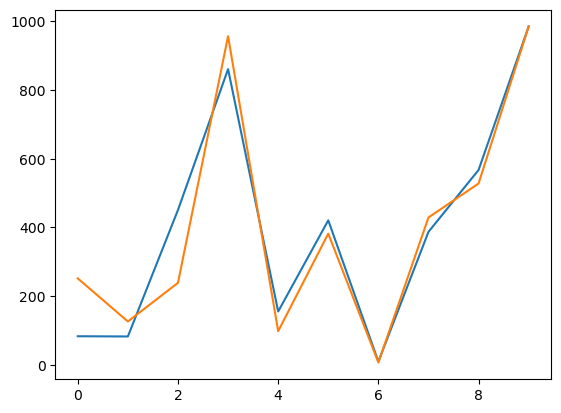

In [45]:
#Plotting current wealth and updated wealth for each agent for one time-step
import matplotlib.pyplot as plt

plt.plot(g.ndata['k'])
plt.plot(g.ndata['k_new'])

In [46]:
#Checking for continuity of wealth
print (sum(g.ndata['k']) - sum(g.ndata['k_new']))

tensor([-0.0002])
